# A* search problem

## Introduction
Search algorithms play a crucial role in many areas of computer science and artificial intelligence, particularly in pathfinding and graph traversal tasks. This lab focuses on implementing four fundamental search algorithms:

Uninformed Search Strategies:
- Depth-First Search (DFS)
- Breadth-First Search (BFS)

Informed Search Strategies:
- Uniform Cost Search (UCS)
- A* Search

Students will apply these algorithms to a grid-based navigation problem, identifying the most efficient path from a start point to a goal point while avoiding obstacles.

## Environment Setup:

Implement a environment class to model the navigation environment as a 2D grid.
The grid should include obstacles, a start point (S), and a goal point (G).
Implement Search Algorithms:

Implement the DFS and BFS algorithms to explore the grid.
Implement the UCS and A* Search algorithms, utilizing cost functions and heuristics to find optimal paths.

Visualization:

Use a visualization library (e.g., matplotlib) to visually represent the grid, the obstacles, and the paths found by each algorithm.

# Agent Class with a A* Example

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from collections import deque
import heapq

class PriorityQueue:
    def __init__(self):
        self.elements = []

    def empty(self):
        return len(self.elements) == 0

    def put(self, item, priority):
        heapq.heappush(self.elements, (priority, item))

    def get(self):
        return heapq.heappop(self.elements)[1]

class Node:
    def __init__(self, state, parent=None, action=None, path_cost=0, charge = 100):
        self.state = state  # The current position of the agent in the grid.
        self.parent = parent  # The node in the search tree that generated this node.
        self.action = action  # The action taken to get to this state.
        self.path_cost = path_cost  # Cost from the start node to this node.
        self.charge = charge  # charge in this node

    # Comparison operator for priority queue.
    def __lt__(self, other):
        return self.path_cost < other.path_cost


In [20]:
def heuristic(a, b):
    (x1, y1) = a
    (x2, y2) = b
    return abs(x1 - x2) + abs(y1 - y2)


In [21]:
# Environment Class represents the grid and handles state transitions.
class Environment:
    def __init__(self, grid, start, goal):
        self.grid = grid  # The grid layout where 1 represents an obstacle and 0 is free space.
        self.initial = start  # Starting position of the agent.
        self.goal = goal  # Goal position the agent aims to reach.

    # Returns the possible actions from a given state.
    def actions(self, state):
        possible_actions = ['UP', 'DOWN', 'LEFT', 'RIGHT']
        x, y = state

        # Remove impossible actions based on grid boundaries and obstacles.
        if x == 0 or self.grid[x - 1][y] == 1:
            possible_actions.remove('UP')
        if x == len(self.grid) - 1 or self.grid[x + 1][y] == 1:
            possible_actions.remove('DOWN')
        if y == 0 or self.grid[x][y - 1] == 1:
            possible_actions.remove('LEFT')
        if y == len(self.grid[0]) - 1 or self.grid[x][y + 1] == 1:
            possible_actions.remove('RIGHT')

        return possible_actions

    # Returns the state resulting from taking a given action at a given state.
    def result(self, state, action):
        x, y = state
        if action == 'UP':
            return (x - 1, y)
        if action == 'DOWN':
            return (x + 1, y)
        if action == 'LEFT':
            return (x, y - 1)
        if action == 'RIGHT':
            return (x, y + 1)

    # Checks if the goal has been reached.
    def is_goal(self, state):
        return state == self.goal

In [22]:
class Agent:
    def __init__(self, env):
        self.env = env

    def uniform_cost_search(self):
        frontier = PriorityQueue()  # Priority queue for UCS.
        frontier.put(Node(self.env.initial, path_cost=0), 0)
        came_from = {self.env.initial: (None, 100)}
        cost_so_far = {self.env.initial: 0}

        while not frontier.empty():
            current_node = frontier.get()

            if self.env.is_goal(current_node.state):
                return self.reconstruct_path(came_from, current_node.state)

            for action in self.env.actions(current_node.state):
                new_state = self.env.result(current_node.state, action)
                new_cost = cost_so_far[current_node.state] + 1  # Assuming uniform cost for simplicity; adjust if varying costs.
                if new_state not in cost_so_far or new_cost < cost_so_far[new_state]:
                    cost_so_far[new_state] = new_cost
                    charge = current_node.charge - 10
                    if charge == 0:
                      charge = 100
                    priority = new_cost
                    frontier.put(Node(new_state, current_node, action, new_cost, charge), priority)
                    came_from[new_state] = (current_node.state, charge)

        return []

    def a_star_search(self):
        # The start node is created with a path cost of 0.
        start_node = Node(self.env.initial, path_cost=0)
        frontier = PriorityQueue()
        frontier.put(start_node, 0)  # Priority is f-cost, initially the heuristic cost from start to goal
        came_from = {self.env.initial: (None, 100)}  # Tracks the best path to a node -> dict
        cost_so_far = {self.env.initial: 0}  # Tracks the g-cost (cost so far to reach a node) -> dict

        while not frontier.empty():
            current_node = frontier.get()

            if self.env.is_goal(current_node.state):
                return self.reconstruct_path(came_from, current_node.state)

            for action in self.env.actions(current_node.state):
                new_state = self.env.result(current_node.state, action)
                new_cost = cost_so_far[current_node.state] + 1  # Assuming uniform cost for simplicity
                if new_state not in cost_so_far or new_cost < cost_so_far[new_state]:
                    cost_so_far[new_state] = new_cost
                    charge = current_node.charge - 10
                    if charge == 0:
                      charge = 100
                    priority = new_cost + heuristic(new_state, self.env.goal)  # f-cost = g-cost + h-cost
                    frontier.put(Node(new_state, current_node, action, new_cost, charge), priority)
                    came_from[new_state] = (current_node.state, charge)

        return []

    def reconstruct_path(self, came_from, current):
        path = []
        chargeStation = []
        while current in came_from:
            path.append((current, came_from[current][1]))
            current = came_from[current][0]
        # path.append(self.env.initial, 0)  # Start node is not in came_from
        path.reverse()  # Reverse to get the path from start to goal
        return path


In [23]:
# Generate a Random Grid Function
def generate_random_grid(size, obstacle_probability):
    return np.random.choice([0, 1], size=(size, size), p=[1-obstacle_probability, obstacle_probability])

# Define the size of the grid and the probability of an obstacle in each cell
grid_size = 10
obstacle_probability = 0.2  # 20% chance of being an obstacle

# Generate a random grid
grid = generate_random_grid(grid_size, obstacle_probability)

# Define start and goal positions
start = (0, 0)
goal = (grid_size - 1, grid_size - 1)

# Ensure start and goal are not obstacles
grid[start] = 0
grid[goal] = 0

# Create the environment and agent
environment = Environment(grid, start, goal)
agent = Agent(environment)

# Solve the problem with the A* algorithm
ans_a_star = agent.a_star_search()
ans_ucs = agent.uniform_cost_search()

solution_path_a_star = []
Charge_station_a_star = []

for items, charge in ans_a_star:
  solution_path_a_star.append(items)
  if charge == 100:
    Charge_station_a_star.append(items)

if len(Charge_station_a_star) > 0:
   Charge_station_a_star.pop(0)

solution_path_ucs = []
Charge_station_ucs = []

for items, charge in ans_ucs:
  solution_path_ucs.append(items)
  if charge == 100:
    Charge_station_ucs.append(items)

if len(Charge_station_ucs) > 0:
   Charge_station_ucs.pop(0)


In [24]:
# Visualization Function plots the grid and the found path.
def visualize_grid_and_path(grid, path, Charge_station):
    grid_array = np.array(grid)  # Convert grid to numpy array for easy plotting.
    fig, ax = plt.subplots()
    ax.imshow(grid_array, cmap='Greys', alpha=0.3)  # Grid background.
    start = path[0]
    goal = path[-1]

    ax.plot(start[1], start[0], 'bs', markersize=10)  # Start position in blue.
    ax.plot(goal[1], goal[0], 'gs', markersize=10)  # Goal position in green.

    for charge in Charge_station:
      ax.plot(charge[1], charge[0], 'rs', markersize=10)

    xs, ys = zip(*path)  # Extract X and Y coordinates of the path.
    ax.plot(ys, xs, 'r-', linewidth=2)  # Plot the path in red.
    ax.set_xticks(np.arange(-.5, len(grid[0]), 1), minor=True)
    ax.set_yticks(np.arange(-.5, len(grid), 1), minor=True)
    ax.grid(which="minor", color="b", linestyle='-', linewidth=1)
    ax.tick_params(which="minor", size=0)
    ax.tick_params(which="major", bottom=False, left=False, labelbottom=False, labelleft=False)
    plt.show()

Solution Path: [(0, 0), (0, 1), (0, 2), (0, 3), (0, 4), (1, 4), (2, 4), (3, 4), (4, 4), (5, 4), (5, 5), (5, 6), (6, 6), (7, 6), (8, 6), (8, 7), (8, 8), (9, 8), (9, 9)]
Charge Point: [(5, 5)]


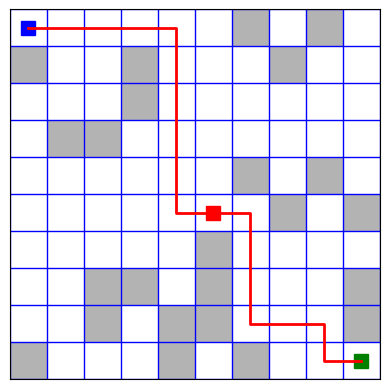

In [25]:
if len(solution_path_a_star) > 0:
  print("Solution Path:", solution_path_a_star)
  print("Charge Point:", Charge_station_a_star)
  visualize_grid_and_path(grid, solution_path_a_star, Charge_station_a_star)
else :
  print("No Path Found")

Solution Path: [(0, 0), (0, 1), (0, 2), (0, 3), (0, 4), (1, 4), (2, 4), (3, 4), (3, 5), (4, 5), (5, 5), (5, 6), (6, 6), (7, 6), (8, 6), (8, 7), (8, 8), (9, 8), (9, 9)]
Charge Point: [(5, 5)]


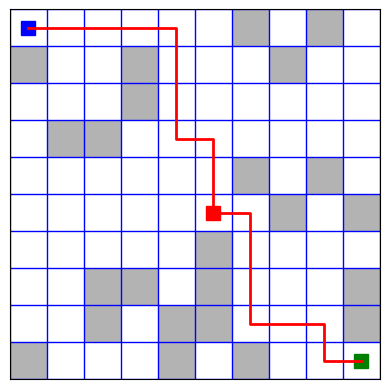

In [26]:
if len(solution_path_ucs) > 0:
  print("Solution Path:", solution_path_ucs)
  print("Charge Point:", Charge_station_ucs)
  visualize_grid_and_path(grid, solution_path_ucs, Charge_station_ucs)
else :
  print("No Path Found")

In [27]:
print("A Star Length :", len(solution_path_a_star))
print("UCS Length :", len(solution_path_ucs))

A Star Length : 19
UCS Length : 19
